In [1]:
# import pandas as pd

# csv_path = 'test.csv'

# dictionary = {'a':['123','234','345'], 'b':['567','678','789']}
# df = pd.DataFrame.from_dict(dictionary, orient='columns')
# print(df)
# df.to_csv(csv_path)


# Import Necessary Libraries

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchtext
import math
from PIL import Image
import math
import torch.nn as nn
from torch.nn import functional as F
from mingpt.utils import CfgNode as CN
import time
from collections import defaultdict
from nltk.translate.bleu_score import sentence_bleu
import warnings
warnings.filterwarnings("ignore") 
torch.cuda.empty_cache()

# Global Variables

In [3]:
csv_path_train = '../All_Data/annotations_train.csv'
image_path_train = '../All_Data/train'
csv_path_valid = '../All_Data/annotations_valid.csv'
image_path_valid = '../All_Data/valid'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
batch_size = 8
epochs = 10
n_embed = 100
glove = torchtext.vocab.GloVe(name="6B",dim=n_embed) # embedding size = 100  
torch.manual_seed(42)
np.random.seed(42)

# Prepare Dataset

In [4]:
class Custom_Dataset(Dataset):
    def __init__(self, image_folder_path, vocab, csv_path, custom_transforms):
        self.image_folder_path = image_folder_path
        annotations = pd.read_csv(csv_path)
        self.captions = np.array(annotations['captions'])
        self.image_names = np.array(annotations['file_directory'])    
        self.custom_transforms = custom_transforms
        self.replace_dict = {'Cockapoo':'parrot', 'Dalmation':'dalmatian', 'Bluetick':'bluebonnet', 'Perenees':'pere', 'Groenendael':'goren', 'Shih-Tzu':'shih', 'Shar_Pei':'shar', 'Komondor':'komon'}
        self.vocab = vocab
        
    def __len__(self):
        return len(self.captions)

    
    def __getitem__(self, idx):
        image_full_name = self.image_folder_path + '/' + self.image_names[idx]
        x = Image.open(image_full_name)
        if self.custom_transforms is not None:
            x = self.custom_transforms(x)
#             x = x.permute(1,2,0)
        ground_truth_cap = self.captions[idx]
        V = len(self.vocab.vectors)
        L = ground_truth_cap.split()
        for i, word in enumerate (L):
            if word in self.replace_dict.keys():
                L[i] = self.replace_dict[word]
                
        tokenized_caption = torch.tensor([self.vocab.stoi.get(w.lower(), V-1) for w in L])  # Use the last word in the vocab as the "out-of-vocabulary" token
        if V-1 in tokenized_caption:
            print('Wrong Labelling')
#         print(image_full_name, ground_truth_cap)        
        return x, tokenized_caption
    
    def get_vocab_size(self):
        return len(self.vocab.vectors)  
    
    def get_block_size(self):
        all_captions_len = []
        for i in range(len(self.captions)):
            all_captions_len.append(len(self.captions[i].split()))
        return max(all_captions_len)+1
    
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.RandomHorizontalFlip(p=0.3),
    torchvision.transforms.RandomRotation(degrees=10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

def lm_collate_fn(batch, device):
    x = [item[0] for item in batch]  
    y_input = [item[1][:-1] for item in batch]  
    y_label = [item[1] for item in batch]
    maxlen_input = max([len(s) for s in y_input])
    maxlen_label = max([len(s) for s in y_label])
    padding_value = glove.stoi.get('unk')
    #x from first word to the second last word, y from second word to the last word
    input_cap, label_cap = [], []
    for sy_i, sy_l in zip(y_input, y_label):
        input_cap.append(torch.cat([sy_i, torch.ones(maxlen_input - len(sy_i))*padding_value]))
        label_cap.append(torch.cat([sy_l, torch.ones(maxlen_label - len(sy_l))*padding_value]))
    return torch.stack(x).long().to(device), torch.stack(input_cap).long().to(device), torch.stack(label_cap).long().to(device)
  
train_dataset = Custom_Dataset(image_path_train, glove, csv_path_train, train_transforms)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn = lambda batch: lm_collate_fn(batch, device))

valid_dataset = Custom_Dataset(image_path_valid, glove, csv_path_valid, valid_transforms)
batch_size = 32
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn = lambda batch: lm_collate_fn(batch, device))

vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_block_size()

# Model

In [5]:
#model.py
# -----------------------------------------------------------------------------

class NewGELU(nn.Module):

    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x)))) # MLP forward

    def forward(self, x):
        #x.shape = (batch, sent len, embedding)
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class GPT(nn.Module):
    """ GPT Language Model """

    @staticmethod
    def get_default_config():
        C = CN()
        # either model_type or (n_layer, n_head, n_embd) must be given in the config
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd =  None
        # these options must be filled in externally
        C.vocab_size = None
        C.block_size = None
        # dropout hyperparameters
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        return C

    def __init__(self, config, vocab):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.block_size = config.block_size

        type_given = config.model_type is not None
        params_given = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        assert type_given ^ params_given # exactly one of these (XOR)
        if type_given:
            # translate from model_type to detailed configuration
            config.merge_from_dict({
                # names follow the huggingface naming conventions
                # GPT-1
                'openai-gpt':   dict(n_layer=12, n_head=12, n_embd=768),  # 117M params
                # GPT-2 configs
                'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
                'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
                'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
                'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
                # Gophers
                'gopher-44m':   dict(n_layer=8, n_head=16, n_embd=512),
                # (there are a number more...)
                # I made these tiny models up
                'gpt-mini':     dict(n_layer=5, n_head=5, n_embd=n_embed),
                'gpt-micro':    dict(n_layer=4, n_head=4, n_embd=128),
                'gpt-nano':     dict(n_layer=3, n_head=3, n_embd=48),
            }[config.model_type])

        #wte is embedding for words
        #wpe is embedding for positions
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding.from_pretrained(vocab.vectors, freeze = True),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def configure_optimizers(self, train_config, cnn_model_params):
        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )
        if cnn_model_params is not None:
            # create the pytorch optimizer object
            optim_groups = [
                {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
                {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
                {"params": cnn_model_params,'lr': 3e-5}
            ]
            
            n_parameters_transformer = sum(p.numel()
               for p in self.parameters() if p.requires_grad)
            n_parameters_cnn = sum(p.numel()
                           for p in cnn_model_params if p.requires_grad)
            print(f"Number of trainable params: {n_parameters_transformer + n_parameters_cnn}")
        else:
            # create the pytorch optimizer object
            optim_groups = [
                {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
                {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0}
            ]  
        
            n_parameters_transformer = sum(p.numel()
                           for p in self.parameters() if p.requires_grad)
            print(f"Number of trainable params: {n_parameters_transformer}")
        
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, image_embed, idx=None, targets=None, finetune_classify=False):

        device = image_embed.device
  
        if idx is not None:
            b, t = idx.size()
            assert t <= self.block_size, f"Cannot forwarnd sequence of length {t}, block size is only {self.block_size}"
            pos = torch.arange(0, t+1, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

            # forward the GPT model itself
            tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
            tok_emb = torch.cat((image_embed.unsqueeze(1), tok_emb), 1)
          
        else:
            pos = torch.arange(0, 1, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)
            tok_emb = image_embed.unsqueeze(1)   
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        
        assert tok_emb[0].shape == pos_emb[0].shape, f"wrong token or position embedding"
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        #x.shape = (batch, sentence len, embedding)
        if not finetune_classify:
            # LM forward procedure
            logits = self.lm_head(x)
        else:
            # Finetune classify procedure
            print('error')
            return
            
        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        return logits, loss


In [6]:
# set up model configurations
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-mini'
model_config.vocab_size = vocab_size
#block_size is a max sentence length in dataset
model_config.block_size = block_size
model = GPT(model_config, glove)

number of parameters: 40.61M


# Load Model and Generate Words

In [7]:
import torch
cnn_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True,)
cnn_model.classifier = nn.Sequential(nn.Linear(1280, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, n_embed))

model.load_state_dict(torch.load('./saved_checkpoints/best_transformer.pt'))
model.eval()
model.to(device)

cnn_model.load_state_dict(torch.load('./saved_checkpoints/best_cnn.pt'))
cnn_model.eval()
cnn_model.to(device)
max_new_tokens = block_size-1


Using cache found in C:\Users\zixua/.cache\torch\hub\pytorch_vision_v0.10.0


The input image is:


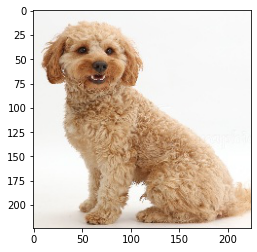

The generated captions are:
This is a white and black standing japanese spaniel dog on the grass
This is a yellow and black standing german sheperd dog
This is a white and yellow standing basset dog
This is a white and brown standing saint bernard dog
The average BLEU score is:
Average BLEU score for 4 generated captions is 0.438631154100826




In [21]:
def generate(image_path, device, max_new_tokens, temperature=1.0, top_p=None, top_k=None):
    if top_p is not None and top_k is not None:
        print('Only one sampling approach is allowed')
        return
    if top_p is None and top_k is None:
        print('You must select a sampling approach')
        return
    reverse_replace_dict = {'parrot':'Cockapoo', 'dalmatian':'Dalmation', 'bluebonnet':'Bluetick', 'pere':'Perenees', 'goren':'Groenendael', 'shih':'Shih-Tzu', 'shar':'Shar_Pei', 'komon':'Komondor'}
    generation_prob = []
    generation_word = []
    idx = None
    image_file = Image.open(image_path)
    image_tensor = valid_transforms(image_file).unsqueeze(0).to(device)
    image_embedding = cnn_model(image_tensor)
    for _ in range(max_new_tokens):
        logits, _ = model(image_embedding, idx)
        # pluck the logits at the final step and scale by desired temperature
        logits = logits[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        if top_k is not None:
            idx_next_prob, idx_next = torch.topk(probs, k=top_k, dim=-1)
            
        if top_p is not None:
            top_k = 1
            idx_next_prob, idx_next = torch.topk(probs, k=top_k, dim=-1)
            while idx_next_prob.detach().cpu().sum().item() < top_p:
                top_k += 1
                idx_next_prob, idx_next = torch.topk(probs, k=top_k, dim=-1)
                
        idx_next_prob, idx_next = idx_next_prob[0].detach().cpu(), idx_next[0].detach().cpu()
        sum_prob = idx_next_prob.sum().item()
        idx_next_prob = [prob_i/sum_prob for prob_i in idx_next_prob.tolist()]
        idx_next_prob[-1] = 1 - sum(idx_next_prob[:-1]) 
        if idx_next_prob[-1] < 0:
            idx_next_prob[-1] = 0
            index = -1
            while sum(idx_next_prob[:index]) > 1:
                idx_next_prob[index-1] = 0
                index -= 1
            idx_next_prob [index] = 1 - sum(idx_next_prob[:index])

        select_token = np.random.choice(idx_next.tolist(), 1, p=idx_next_prob)  
        for token, token_prob in zip(idx_next, idx_next_prob):
            if token == select_token[0]:
                generation_prob.append(token_prob)    
       
        next_word = glove.itos[select_token[0]]

        if next_word in reverse_replace_dict.keys():
            next_word = reverse_replace_dict[next_word]
            
        if next_word == '.':
            break        
            
        generation_word.append(next_word)
#         test_prob, test_next = torch.topk(probs, k=2, dim=-1)
#         print(test_prob)
#         print(glove.itos[test_next[0, 0].detach().cpu().item()], glove.itos[test_next[0, 1].detach().cpu().item()])            
            
            
        idx_next = torch.tensor(select_token).unsqueeze(0).to(device)
        if idx is None:
            # append sampled index to the running sequence and continue
            idx = idx_next
        else:
            idx = torch.cat((idx, idx_next), dim=1)
        

    return generation_word, generation_prob




def generate_n_captions(image_path, num_examples, reference):
    image = Image.open(image_path)
    print('The input image is:')
    plt.imshow(image, vmin=0, vmax=255)
    plt.show()
    all_generation_word = []
    all_generation_prob = []
    print('The generated captions are:')
    for _ in range(num_examples):
        generation_word, generation_prob = generate(image_path, device, max_new_tokens, temperature=1, top_p=None, top_k=3)
        all_generation_word.append(generation_word)
        all_generation_prob.append(generation_prob)
        combined_string = ''
        for i, word in enumerate (generation_word):
            if i != 0:
                combined_string += ' '
            combined_string += generation_word[i]    

        #result = tokenizer.decode(output[0], skip_special_tokens=True)
        print(combined_string.capitalize())
    print('The average BLEU score is:')
    BLEU_score = []
    for generation_word in all_generation_word:
        BLEU_score.append(sentence_bleu(reference, generation_word, weights=[1]))

    print('Average BLEU score for {} generated captions is {}'.format(num_examples, sum(BLEU_score)/len(BLEU_score)))          
    print('\n')
    
image_path = '../All_Data/valid/Cockapoo/1.jpg'        
num_examples = 4
reference = [
            'this is a sitting dog'.split(),
            'this is a sitting cockapoo dog'.split(),
            'this is a yellow sitting cockapoo dog'.split(),
            'this is a yellow sitting cockapoo dog in the blank background'.split()
            ]
generate_n_captions(image_path, num_examples, reference)


The input image is:


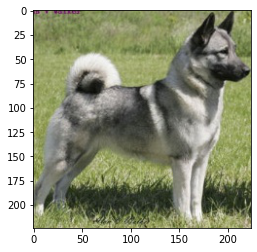

The generated captions are:
This is a standing dog
This is a white and brown standing blenheim dog
This is a white and black standing japanese spaniel dog
This is a standing dog
The average BLEU score is:
Average BLEU score for 4 generated captions is 0.8739965338250164




In [23]:
image_path = '../All_Data/valid/Elk Hound/2.jpg'        
reference = [
            'this is a standing dog'.split(),
            'this is a standing elk hound dog'.split(),
            'this is a black and white standing elk hound dog'.split(),
            'this is a black and white standing elk hound dog on the grass'.split()
            ]
generate_n_captions(image_path, num_examples, reference)